In [1]:
import json
import pandas as pd
import numpy as np
from pprint import pprint
import operator
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from gap_statistic import OptimalK
from sklearn.metrics import jaccard_similarity_score
from scipy import spatial
pd.set_option('display.max_columns', 500)

In [2]:
data = list()

with open('chennai_place_data_4km.json') as f:
    for line in f:
        data.append(json.loads(line))

In [3]:
list_dict = []

for idx, d in enumerate(data):
    if isinstance(d, dict):
        #print({idx: d})
        list_dict.append(d)
        
df = pd.DataFrame(list_dict)
#df.head()

In [4]:
#Filtering types 

l=[]
for i in range(len(df)):
    y=[]
    x = df.types[i]
    j=0
    while x[j]!='point_of_interest':
        y.append(x[j])
        j+=1
    l.append(y)
flat_list = [item for y in l for item in y]
#len(set(flat_list))
df['types'] = l

In [5]:
#Dictionary with types to count mapping

d = dict()
for item in list(set(flat_list)):
    d[item] = flat_list.count(item)
    
d = sorted(d.items(), key=operator.itemgetter(1))
    

In [6]:
#Forming one hot vector for each place

l = [x[0] for x in d]
li = list()
for i in range(len(df)):
    di = dict()
    types = df.types[i]
    com_el = list(set(types).intersection(l))
    for j in range(len(l)):
        if l[j] in com_el:
            di[l[j]]=1
        else:
            di[l[j]]=0
    li.append(di)
            

In [7]:
x = []
for d in li:
    x.append(list(d.values()))
    

In [8]:
data = pd.DataFrame(data=x,columns = list(li[0].keys()))
data.head(2)

,bicycle_store,gas_station,electronics_store,grocery_or_supermarket,spa,veterinary_care,courthouse,fire_station,art_gallery,clothing_store,shopping_mall,laundry,storage,bank,real_estate_agency,moving_company,parking,pet_store,rv_park,doctor,movie_rental,insurance_agency,hindu_temple,lodging,stadium,zoo,store,locksmith,travel_agency,lawyer,finance,shoe_store,gym,hardware_store,liquor_store,florist,book_store,political,bowling_alley,airport,bar,jewelry_store,casino,park,church,meal_delivery,cemetery,convenience_store,post_office,department_store,car_wash,furniture_store,dentist,subway_station,night_club,pharmacy,school,physiotherapist,hospital,bus_station,synagogue,car_rental,car_repair,library,subpremise,meal_takeaway,plumber,university,cafe,electrician,natural_feature,mosque,bakery,car_dealer,premise,restaurant,painter,movie_theater,roofing_contractor,city_hall,aquarium,police,atm,place_of_worship,amusement_park,transit_station,hair_care,taxi_stand,campground,local_government_office,home_goods_store,beauty_salon,food,embassy,route,funeral_home,train_station,supermarket,museum,accounting,health,general_contractor
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [126]:
minor = list(set([x for sub in minors for x in sub]))

In [73]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [84]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(data, 50))

Top Absolute Correlations
transit_station          bus_station               0.896362
hindu_temple             place_of_worship          0.807327
food                     restaurant                0.691967
atm                      finance                   0.682500
grocery_or_supermarket   supermarket               0.602594
home_goods_store         furniture_store           0.598919
bank                     finance                   0.583160
doctor                   health                    0.489524
health                   pharmacy                  0.478301
church                   place_of_worship          0.476406
food                     cafe                      0.422331
bakery                   food                      0.419994
health                   gym                       0.405026
                         dentist                   0.396942
restaurant               meal_takeaway             0.367885
store                    home_goods_store          0.346646
accounting    

In [9]:
#Finding distribution of each major category

major = ['transit_station','place_of_worship','food','finance','health','store']
maind = dict()
for item in major:
    sub_catd = dict()
    for i in range(len(df)):
        
        if item in df.types[i]:
            sub_cat = [x for x in df.types[i] if x not in item]
            #print (i,sub_cat)
            #print (i)
            if sub_cat:
                if sub_cat[0] in list(sub_catd.keys()):
                #print ('i am here')
                    sub_catd[sub_cat[0]]+=1
                else:
                    sub_catd[sub_cat[0]]=1
            #print (sub_catd)
    maind[item]=sorted(sub_catd.items(), key=operator.itemgetter(1),reverse=True)
            
            #sub_cat = set(df.types[i])-set(item)
            #sub_catd
            
    
#Finding top sub categories for major categories

sub_cat = []
for cat in list(maind.keys()):
    total = sum([x[1] for x in maind[cat]])
    n = 0
    for i in range(len(maind[cat])):
        n+=maind[cat][i][1]
        if (n/total)<=0.95:
            #print (cat,maind[cat][i][0])
            sub_cat.append(maind[cat][i][0])
    
sub_cat = list(set(sub_cat)-set(major)) +['mosque']
data.head(2)        
        

In [12]:
#Getting latitude and longitude

data['id']=df['id']
data['latitude']=df['geometry'].apply(lambda x:x['location']['lat'])
data['longitude']=df['geometry'].apply(lambda x:x['location']['lng'])
data['latitude']=(data['latitude']-data['latitude'].mean())/data['latitude'].std()
data['longitude']=(data['longitude']-data['longitude'].mean())/data['longitude'].std()

In [13]:
#Removing rows with no major type

index =[]
for i in range(len(data)):
    n=0
    for cat in major:
        #print (cat)
        if data[cat][i]==1:
            n+=1
    if n == 0:
        index.append(i)  
df_major = data.drop(data.index[index]).reset_index(drop=True)

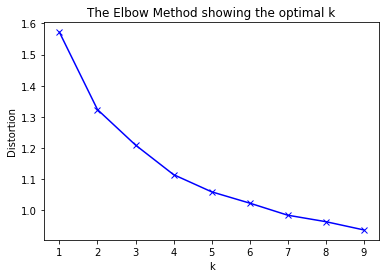

In [47]:
#K-means with major categories

arr = df_major[major+['latitude','longitude']].values

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(arr)
    kmeanModel.fit(arr)
    distortions.append(sum(np.min(cdist(arr, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / arr.shape[0])
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()



In [24]:
from math import*
  
def jaccard_similarity(x,y):
  
 intersection_cardinality = len([element for element in x if element in y])
 #union_cardinality = len(x) + len(y) - intersection_cardinality
 
 return intersection_cardinality
  
print (jaccard_similarity([[1,2],[2,3]],[[1,3],[2,3]]))

1


In [42]:
#Function to get distribution of each cluster

def dic(l,n):
    l = l.tolist()
    d=dict()
    for i in range(n):
        d[i]=l.count(i)
    sorted_x = sorted(d.items(), key=operator.itemgetter(1),reverse=True)
    return (sorted_x)
    #return (d)
        
    
        
#dic([0,1,1,1,1],2)        
        
        
        

In [116]:
#Checking the variance of clusters to get optimum K

arr = df_major[['latitude','longitude']].values
kmeanModel = KMeans(n_clusters=5,init='random').fit(arr)
kmeanModel.fit(arr)
l1 = kmeanModel.labels_
df_major['labels_1']=l1
tup1 = dic(l1,5)
copy = tup1


for i in range(5):
    
    average =0
    avd = 0
    kmeanModel = KMeans(n_clusters=5,init='random').fit(arr)
    kmeanModel.fit(arr)
    l2 = kmeanModel.labels_
    df_major['labels_2'] = l2
    
    tup2 = dic(l2,5)
    
    x=0
    #print (tup1,tup2)
    while len(tup1)>1:
        n=0
        
        item = tup1[x]
        #print (x,tup1)
        df1 = df_major[df_major['labels_1']==item[0]][['latitude','longitude']].values
        s=0
        while len(tup2)>1:
            
            #print (tup1,tup2)
            it = tup2[n]
            df2 = df_major[df_major['labels_2']==it[0]][['latitude','longitude']].values
            
            sim = jaccard_similarity(df1,df2)
            if n<len(tup2)-1:
                
                if (sim>= tup2[n+1][1]):
            
                    avd+=(item[1]+it[1])
                    average+=sim * (item[1]+it[1])
                    tup1.remove(item)
                    tup2.remove(it)
                    n=0
                    x=0

                    break
                else:
                    if s>sim:
                        
                        avd+=(item[1]+it[1])
                        average+=sim * (item[1]+it[1])
                        tup1.remove(item)
                        tup2.remove(tup2[n-1])
                        n=0
                        x=0

                        break
                    else:

                        n+=1
                        x+=1
                    s=0
            else:
                
                if s > sim:
                   
                    avd+=(item[1]+it[1])
                    average+=sim * (item[1]+it[1])
                    tup1.remove(item)
                    tup2.remove(tup2[n-1])
                    n=0
                    x=0
                    
                    break
                
            
            
            s+=sim
    item = tup1[x]
        #print (x,tup1)
    df1 = df_major[df_major['labels_1']==item[0]][['latitude','longitude']].values        
    print (tup1,tup2)
    it = tup2[n]
    df2 = df_major[df_major['labels_2']==it[0]][['latitude','longitude']].values
            
    sim = jaccard_similarity(df1,df2)
    #print (sim,item[0],it[0])
    avd+=(item[1]+it[1])
    average+=sim * (item[1]+it[1])
    print (average/avd)
    tup1 = dic(l2,5)
    
                
                
                
            
     
            
        
        
         
    

0
[(3, 11561)] [(0, 11568)]
20933.50773692398
1
[(0, 11568)] [(0, 11570)]
288.78516014077337
2
[(0, 11570)] [(1, 11501)]
154.2457998093845
3
[(1, 11501)] [(3, 11562)]
6064.030959597919
4
[(3, 11562)] [(3, 11561)]
20506.76181400476


In [141]:
#K-means for sub categories

sub_arr = df_major[sub_cat].values
pca = PCA(n_components=20,svd_solver='full')
X=pca.fit_transform(sub_arr) 
l=[]
for i in range(len(X)):
    a=df_major[['latitude','longitude']].values[i]
    l.append(np.concatenate([a,X[0]]))
#l = np.array(l)           
#sub_arr = df_major[major+['latitude','longitude']].values
kmeans = KMeans(n_clusters=6, random_state=0).fit(l)
df_major['labels_minor']=kmeans.labels_
#centroids = kmeans.cluster_centers_

    
    
